# Computer Vision - Project 3

In [2]:
runtime_environment = 'kaggle'  # local, kaggle
load_models = True

In [3]:
if runtime_environment == 'kaggle':
    !rm -rf semantic-segmentation-clothes
    !git clone https://github.com/vasia-korz/semantic-segmentation-clothes
    !cd semantic-segmentation-clothes
    !ln -sf semantic-segmentation-clothes/classes classes
    !pip install segmentation_models_pytorch

Cloning into 'semantic-segmentation-clothes'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 123 (delta 60), reused 99 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 18.67 KiB | 4.67 MiB/s, done.
Resolving deltas: 100% (60/60), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=f534debc17b4d49a7f06de3c0d959e4c9f6eeca3ee89366aeb7016161f894f65
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=43f3e

In [4]:
%load_ext autoreload
%autoreload 2

from classes.clothes_dataset import ClothesDataset
from classes.segmentation_transform import SegmentationTransform
from classes.utils import visualize, visualize_prediction, plot_history
from classes.models import UnetModel, UnetPlusPlusModel, FPNModel, PSPNetModel, DeepLabV3Model, DeepLabV3PlusModel, LinknetModel, MAnetModel, PANModel, UPerNetModel, SegformerModel

In [5]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch
from itertools import product
import pandas as pd

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [7]:
images_dir = 'data/Images/'
masks_dir = 'data/Masks/'

if runtime_environment == 'kaggle':
    images_dir = '/kaggle/input/people-clothing-segmentation/png_images/IMAGES'
    masks_dir = '/kaggle/input/people-clothing-segmentation/png_masks/MASKS'

dataset = ClothesDataset(images_dir, masks_dir)
random_state = 42

In [8]:
dataset_size = len(dataset)

test_size = int(0.1 * dataset_size)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - test_size - val_size

indices = np.arange(dataset_size)
train_indices, temp_indices = train_test_split(indices, test_size=(test_size + val_size), random_state=random_state)
val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (test_size + val_size)), random_state=random_state)

train_dataset = Subset(ClothesDataset(
    images_dir,
    masks_dir,
    SegmentationTransform(size=(256, 256), normalize=False, augment=True)
), train_indices)

val_dataset = Subset(ClothesDataset(
    images_dir,
    masks_dir,
    SegmentationTransform(size=(256, 256), normalize=False, augment=False)
), val_indices)

test_dataset = Subset(ClothesDataset(
    images_dir,
    masks_dir,
    SegmentationTransform(size=(256, 256), normalize=False, augment=False)
), test_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Number of images: 1000
Size of an image: torch.Size([3, 256, 256])
Size of a mask: torch.Size([256, 256])

Sample image-mask pair:


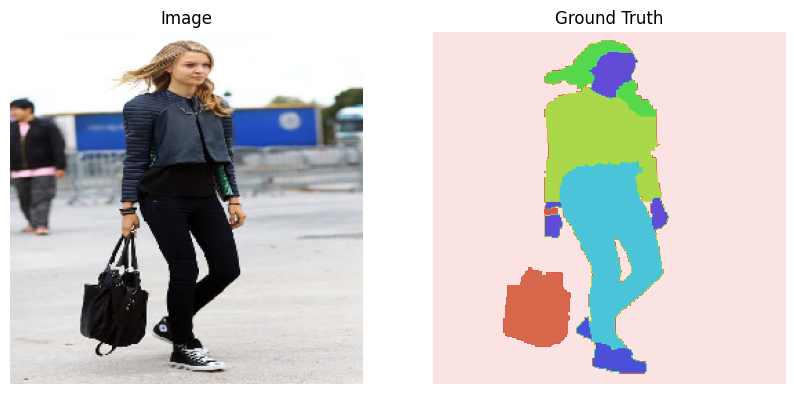

In [9]:
print(f"Number of images: {len(dataset)}\nSize of an image: {train_dataset[0][0].shape}\nSize of a mask: {train_dataset[0][1].shape}")
print(f"\nSample image-mask pair:")
visualize(train_dataset[0])

### Utilities for evaluating the model

In [10]:
def get_evaluation_results(architectures, loss_functions, optimizers, epochs, load_models):
    evaluation_results = []
    history, histories = None, []
    
    combinations = [
        (architecture, loss_fn, optimizer, epoch)
        for architecture, loss_fn, optimizer, epoch
        in product(architectures, loss_functions, optimizers, epochs)
    ]
    
    for architecture, loss_fn, optimizer, epoch in combinations:
        model = models[architecture](loss_fn, optimizer, device=device)
     
        if load_models:
            if runtime_environment == 'local':
                model.load_model(path=f"models/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
            else:
                model.load_model(path=f"/kaggle/working/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
        else:
            print(f"\nTraining model {architecture} (Optim: {optimizer}; Loss: {loss_fn})")
            history = model.train(train_loader, val_loader, epochs=epoch)
            histories.append(history)
            model.save_model(path=f"{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
        
        losses = {}
    
        for eval_loss_fn in ["crossentropy", "dice", "iou"]:
            model.set_loss_fn(eval_loss_fn)
            losses[eval_loss_fn] = model.evaluate(test_loader)
        
        evaluation_results.append({
            "Architecture": architecture,
            "Optimizer": optimizer,
            "Training Loss": loss_fn,
            "CrossEntropy Loss": losses["crossentropy"],
            "Dice Loss": losses["dice"],
            "IOU Loss": losses["iou"]
        })

    return evaluation_results, histories


def plot_models_preds(architectures, loss_functions, optimizers, epochs, limit=3):
    combinations = [
        (architecture, loss_fn, optimizer, epoch)
        for architecture, loss_fn, optimizer, epoch
        in product(architectures, loss_functions, optimizers, epochs)
    ]
    
    for architecture, loss_fn, optimizer, epoch in combinations:
        model = models[architecture](loss_fn, optimizer, device=device)

        if runtime_environment == 'local':
            model.load_model(path=f"models/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
        else:
            model.load_model(path=f"/kaggle/working/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
        
        for images, masks in test_loader:
            i = 0
            print(f"\nPredictions for model {architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
            for image, mask in zip(images, masks):
                visualize_prediction(model.model, (image, mask), device=model.device)
                if (i := i + 1) >= limit:
                    break
            break


# All the architectures
models = {
    "unet": UnetModel,
    "unetplusplus": UnetPlusPlusModel,
    "fpn": FPNModel,
    "pspnet": PSPNetModel,
    "deeplabv3": DeepLabV3Model,
    "deeplabv3plus": DeepLabV3PlusModel,
    "linknet": LinknetModel,
    "manet": MAnetModel,
    "pan": PANModel,
    "upernet": UPerNetModel,
    "segformer": SegformerModel,
}

### Choosing the best loss function

In the first step we want to identify the best loss function for the given dataset. We decide to evaluate **3 loss functions** on the baseline model (UNet with Adam optimizer trained for 10 epochs). Considering that loss functions are usually appropriate for datasets / problems rather than for the architectures, we are going to conduct all further experiments using the best identified loss (one of the following: `IOU`, `Dice`, `CrossEntropy`).

In [11]:
architectures = ["unet"]
loss_functions = ["crossentropy", "iou", "dice"]
optimizers = ["adam"]
epochs = [10]

eval_res, _ = get_evaluation_results(
    architectures, 
    loss_functions, 
    optimizers, 
    epochs, 
    load_models=True
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 262MB/s]
Evaluation: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


In [12]:
pd.DataFrame(eval_res)

Architecture Optimizer Training Loss  CrossEntropy Loss  Dice Loss  IOU Loss
0         unet      adam  crossentropy           0.542213   0.340874  0.363323
1         unet      adam           iou           2.473103   0.341384  0.362038
2         unet      adam          dice           3.039970   0.321907  0.348526

From the table above we conclude:

* `CrossEntropy` is optimized poorly when loss function is set to `Dice` or `IOU`, however, when optimizing `CrossEntropy`, other metrics are also optimized well.

That leads us to conclusion that `CrossEntropy` is the most promising loss function. Though, we also check the outputs of each model below.


Predictions for model unet_crossentropy_adam_10.pth


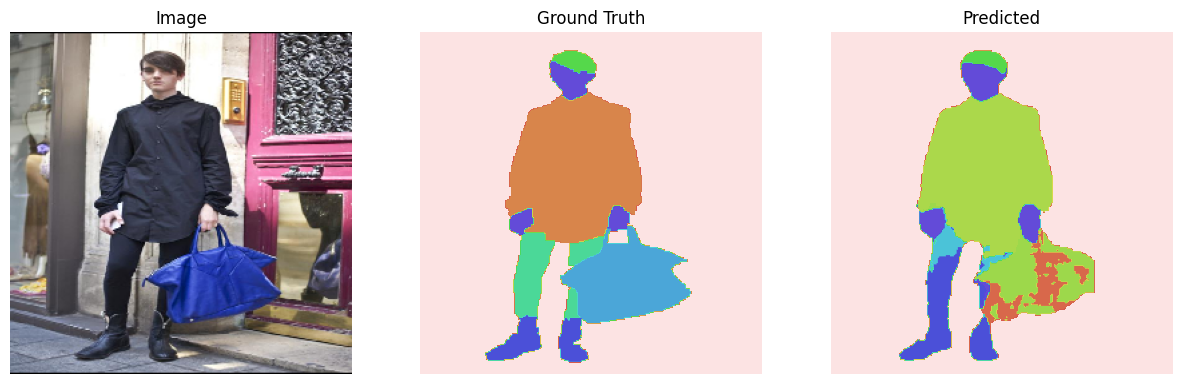

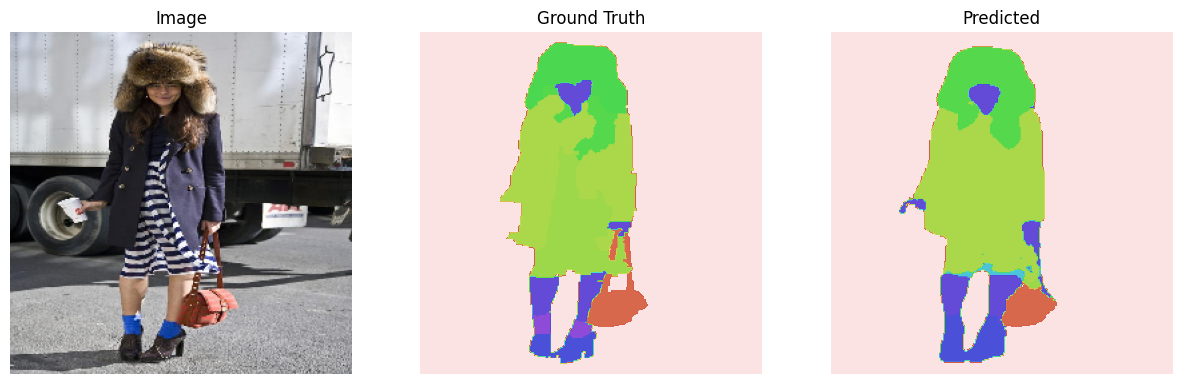

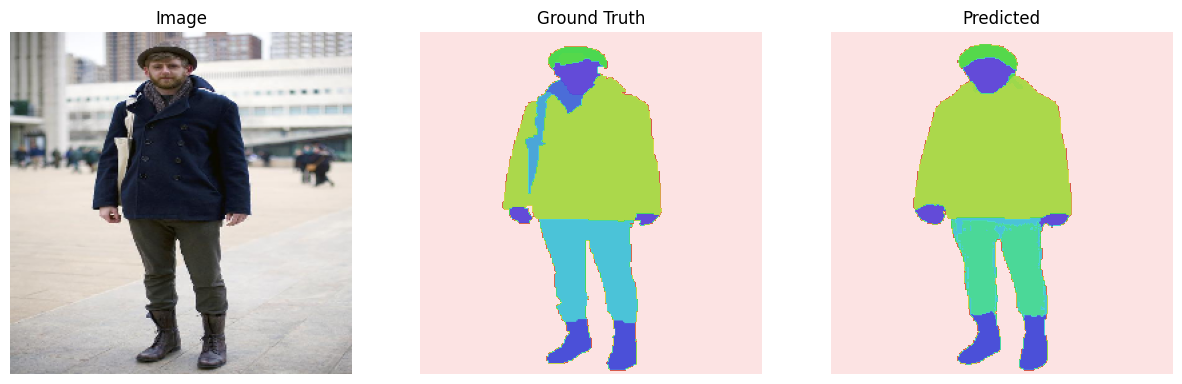


Predictions for model unet_iou_adam_10.pth


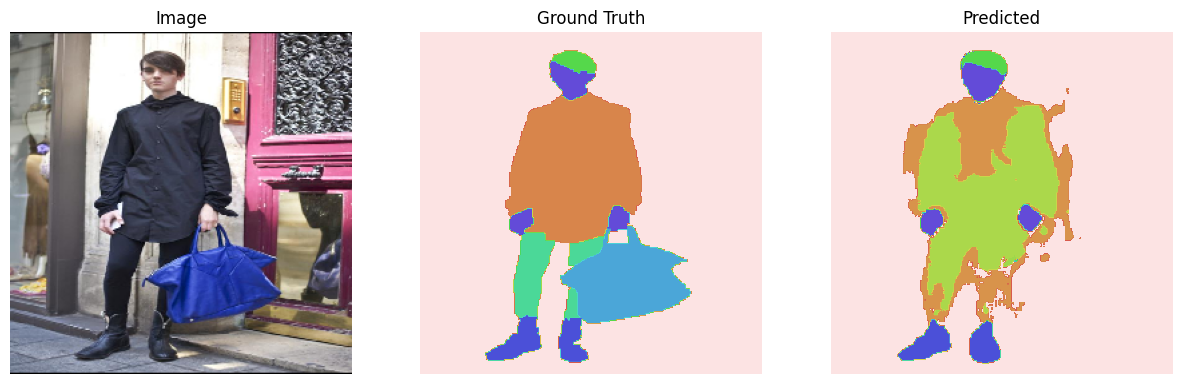

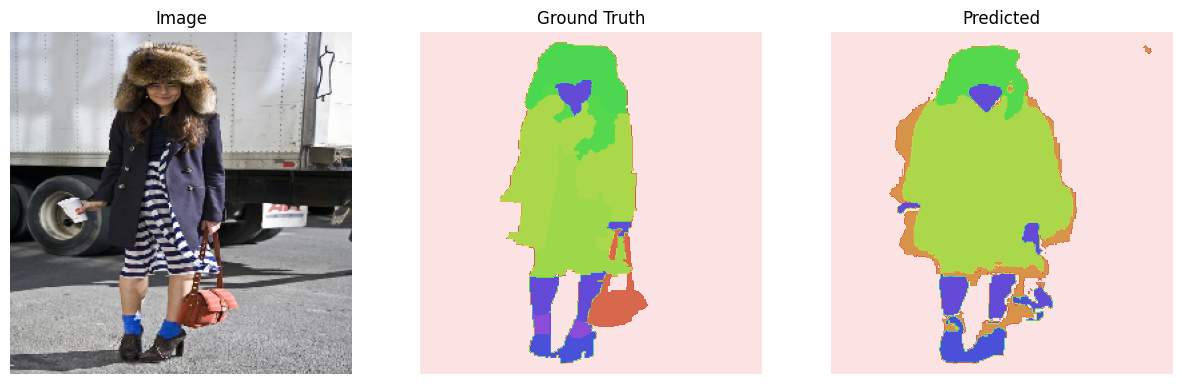

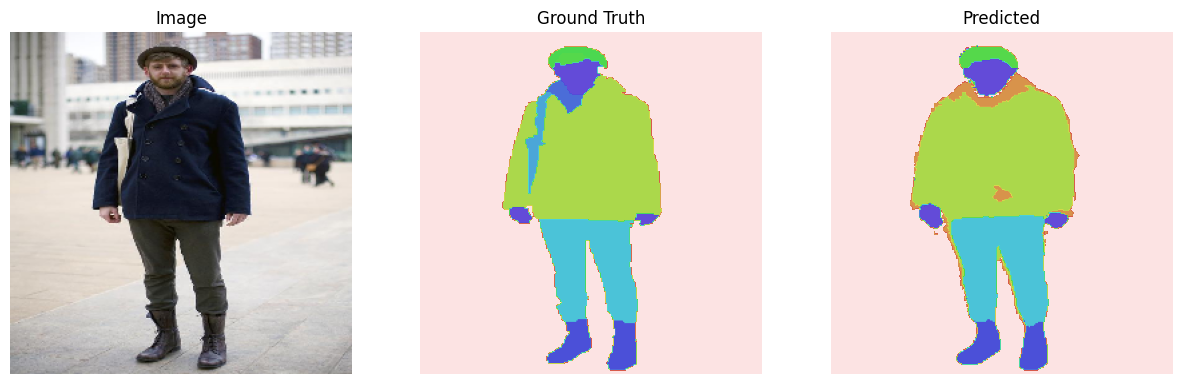


Predictions for model unet_dice_adam_10.pth


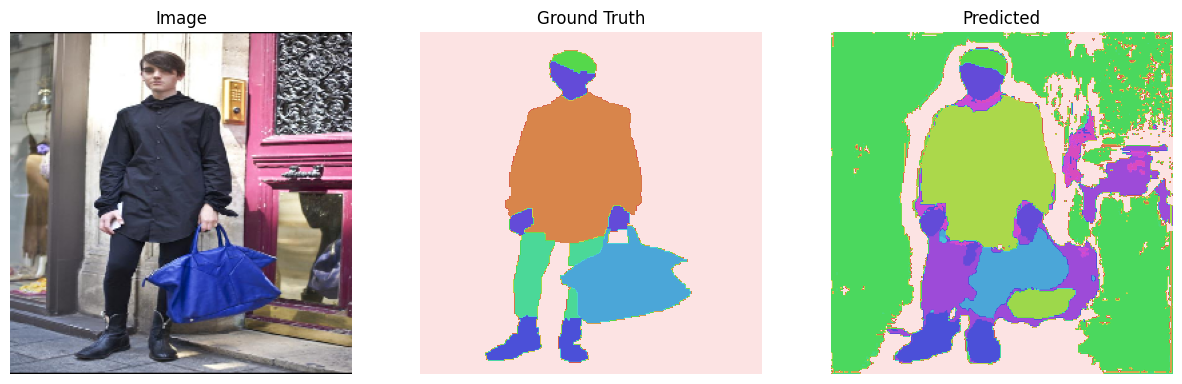

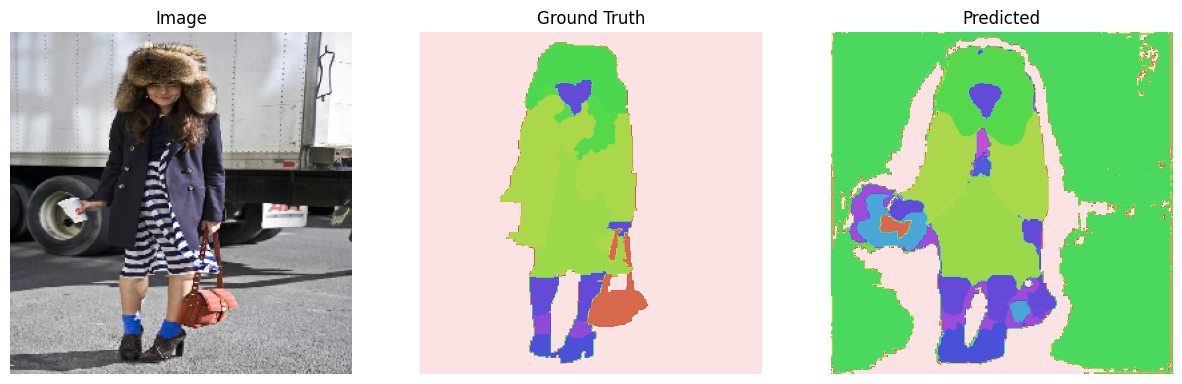

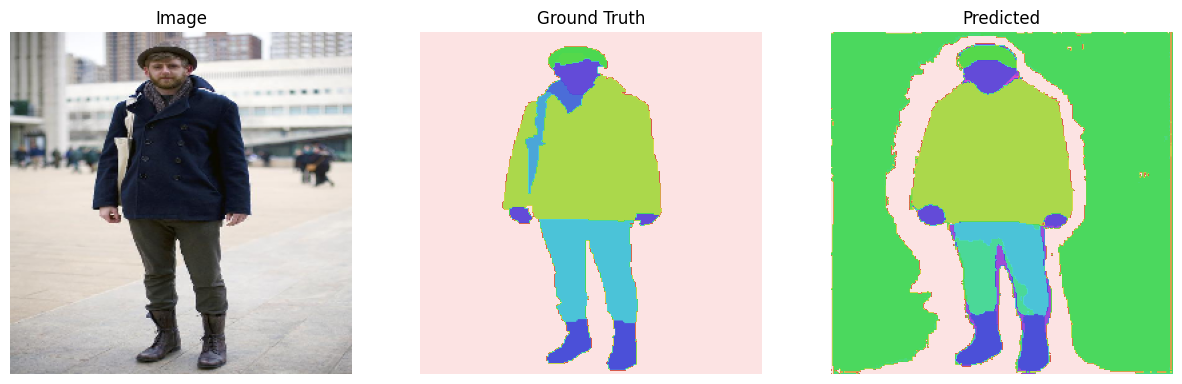

In [13]:
plot_models_preds(
    architectures, 
    loss_functions, 
    optimizers, 
    epochs
)

Even though not perfect, predicted masks are even visually much better when using `CrossEntropy` as a loss function. That is why we will stick with it for the rest of the experiments.

### Identifying the best architecture

In this section we compare performance of 11 models each with different architecture. We consider following architectures:

1. `Unet`
2. `UnetPlusPlus`
3. `FPN`
4. `PSPNet`
5. `DeepLabV3`
6. `DeepLabV3Plus`
7. `Linknet`
8. `MAnet`
9. `PAN`
10. `UPerNet`
11. `Segformer`

All the models are trained using the same backbone (`resnet34`) for consistency.

In [14]:
architectures = list(models.keys())
loss_functions = ["crossentropy"]
optimizers = ["adam"]
epochs = [10]

eval_res, _ = get_evaluation_results(
    architectures,
    loss_functions,
    optimizers,
    epochs,
    load_models=True
)

Evaluation: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


In [15]:
pd.DataFrame(eval_res)

Architecture Optimizer Training Loss  CrossEntropy Loss  Dice Loss  \
0            unet      adam  crossentropy           0.542213   0.340874   
1    unetplusplus      adam  crossentropy           0.518815   0.342450   
2             fpn      adam  crossentropy           0.542840   0.305291   
3          pspnet      adam  crossentropy           0.517548   0.317299   
4       deeplabv3      adam  crossentropy           0.489301   0.309419   
5   deeplabv3plus      adam  crossentropy           0.484020   0.311640   
6         linknet      adam  crossentropy           1.125651   0.391835   
7           manet      adam  crossentropy           0.566822   0.350409   
8             pan      adam  crossentropy           0.518827   0.308114   
9         upernet      adam  crossentropy           0.562205   0.320513   
10      segformer      adam  crossentropy           0.482972   0.287242   

    IOU Loss  
0   0.363323  
1   0.365162  
2   0.334759  
3   0.348303  
4   0.340565  
5   0.342238  
6   0.400958  
7   0.370336  
8   0.340414  
9   0.350496  
10  0.322473

From the table above we conclude:

* While some models are performing poorly and majority of the models performs dicently, model using `Segformer` architecture is the most promising one with all 3 losses being the lowest for it (based on the test set).

### Choosing the best optimizer

We have identified the most promising model (using `Segformer` architecture) in the previous section. We relax our assumptions and we will be considering only this model further.

At this step we compare 3 optimizers:

1. `Adam`
2. `SGD`
3. `RMSprop`

In [16]:
architectures = ["segformer"]
loss_functions = ["crossentropy"]
optimizers = ["adam", "sgd", "rmsprop"]
epochs = [10]

eval_res, _ = get_evaluation_results(
    architectures,
    loss_functions,
    optimizers,
    epochs,
    load_models=True
)

Evaluation: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]


In [17]:
pd.DataFrame(eval_res)

Architecture Optimizer Training Loss  CrossEntropy Loss  Dice Loss  IOU Loss
0    segformer      adam  crossentropy           0.482972   0.287242  0.322473
1    segformer       sgd  crossentropy           0.827034   0.378000  0.391054
2    segformer   rmsprop  crossentropy           0.455173   0.280782  0.317723

From the table above we conclude:

* `Adam` optimizer is the most appropriate for the task / architecture, reaching the lowest losses on all 3 metrics.

At this stage we have already found out that the most promising model contains of:

1. `Segformer` architecture
2. `CrossEntropy` loss function
3. `RMSprop` optimizer

### Final training / evaluation

In the final step we train the most promising model for more than 10 epochs (bounding training by 30 epochs and adding patience of **5** for non-reducing validation loss).

In [23]:
architecture = "segformer"
loss_fn = "crossentropy"
optimizer = "rmsprop"
epoch = 30
patience = 5

evaluation_results = []
history = None

model = models[architecture](loss_fn, optimizer, device=device)

if load_models:
    if runtime_environment == 'local':
        model.load_model(path=f"models/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
    else:
        model.load_model(path=f"/kaggle/working/{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")
else:
    print(f"\nTraining model {architecture} (Optim: {optimizer}; Loss: {loss_fn})")
    history = model.train(train_loader, val_loader, epochs=epoch, patience=patience)
    model.save_model(path=f"{architecture}_{loss_fn}_{optimizer}_{epoch}.pth")

losses = {}
    
for eval_loss_fn in ["crossentropy", "dice", "iou"]:
    model.set_loss_fn(eval_loss_fn)
    losses[eval_loss_fn] = model.evaluate(test_loader)

evaluation_results.append({
    "Architecture": architecture,
    "Optimizer": optimizer,
    "Training Loss": loss_fn,
    "CrossEntropy Loss": losses["crossentropy"],
    "Dice Loss": losses["dice"],
    "IOU Loss": losses["iou"]
})

Evaluation: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


In [24]:
pd.DataFrame(evaluation_results)

Architecture Optimizer Training Loss  CrossEntropy Loss  Dice Loss  IOU Loss
0    segformer   rmsprop  crossentropy           0.445705   0.276572  0.314075

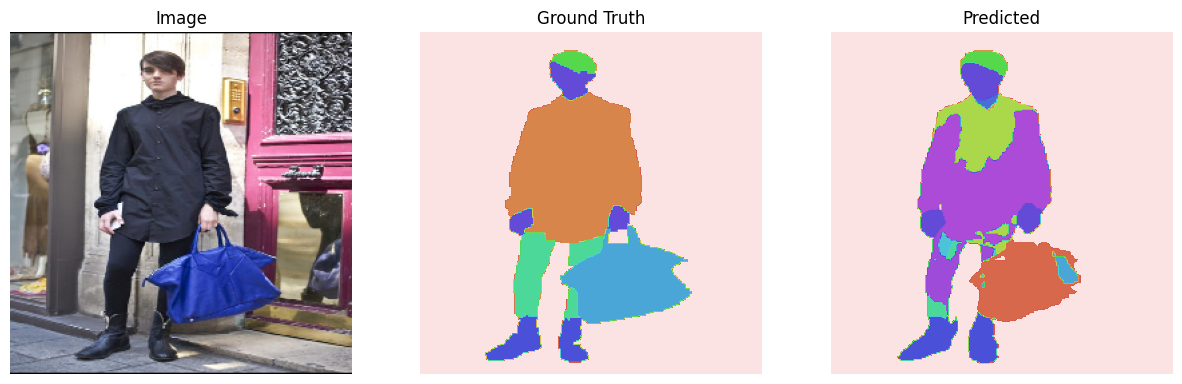

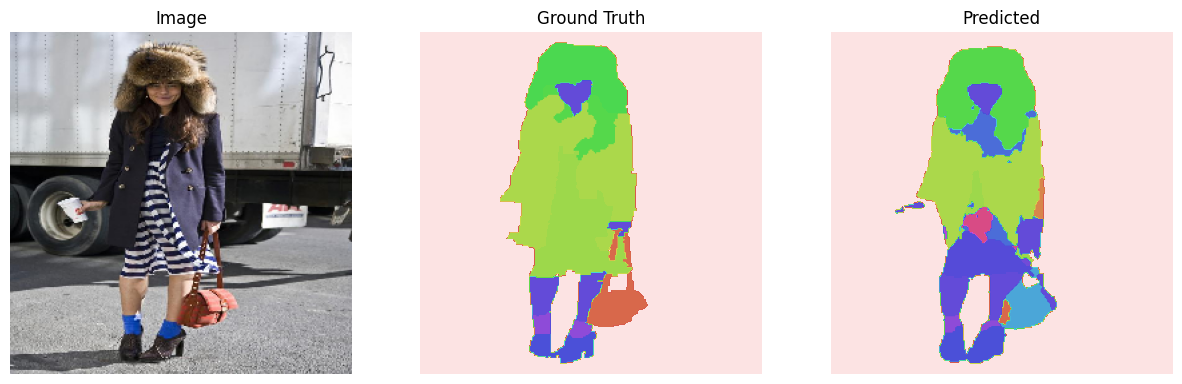

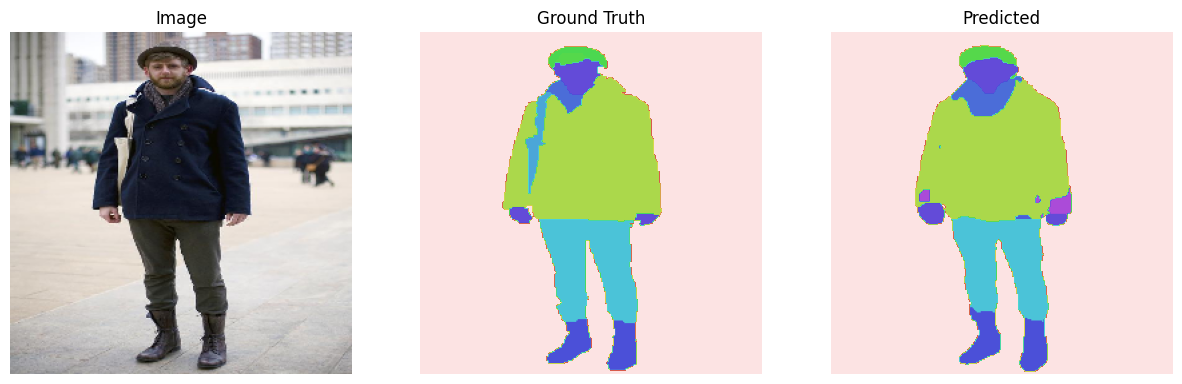

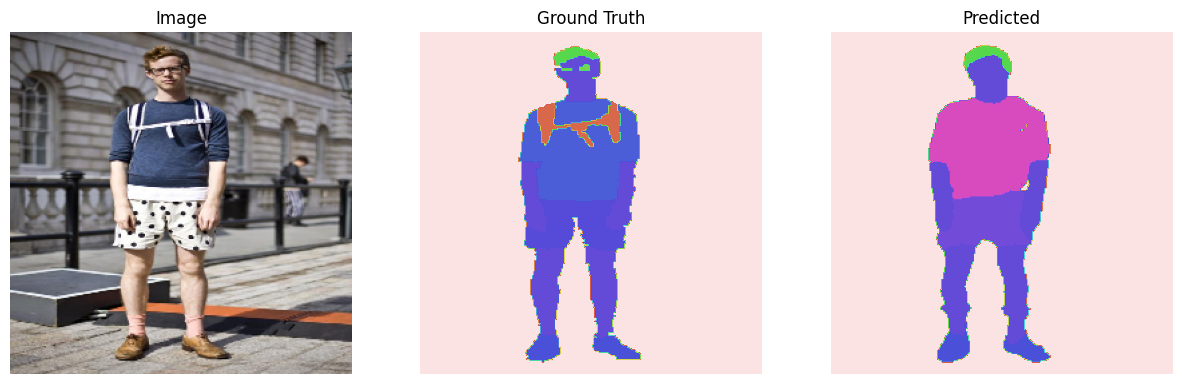

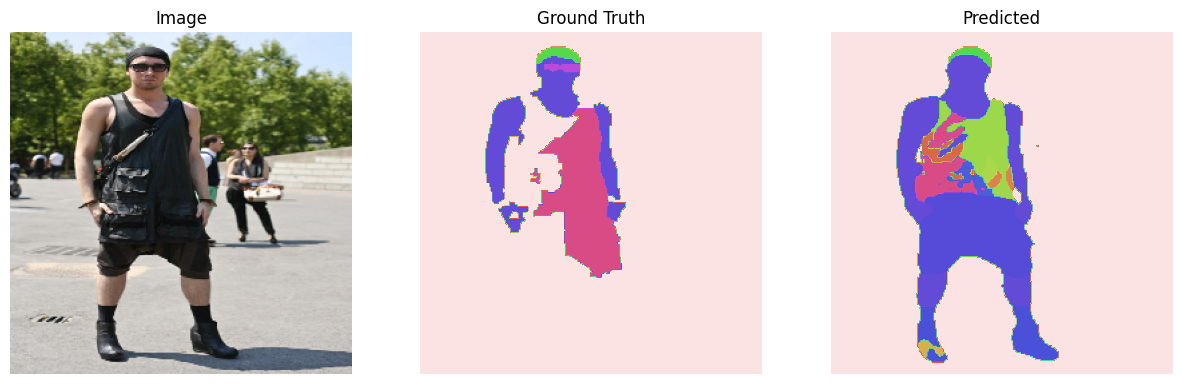

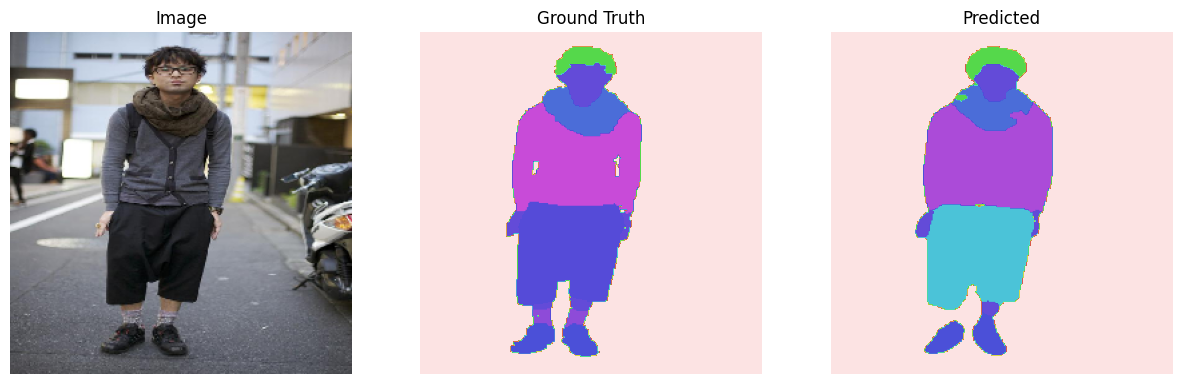

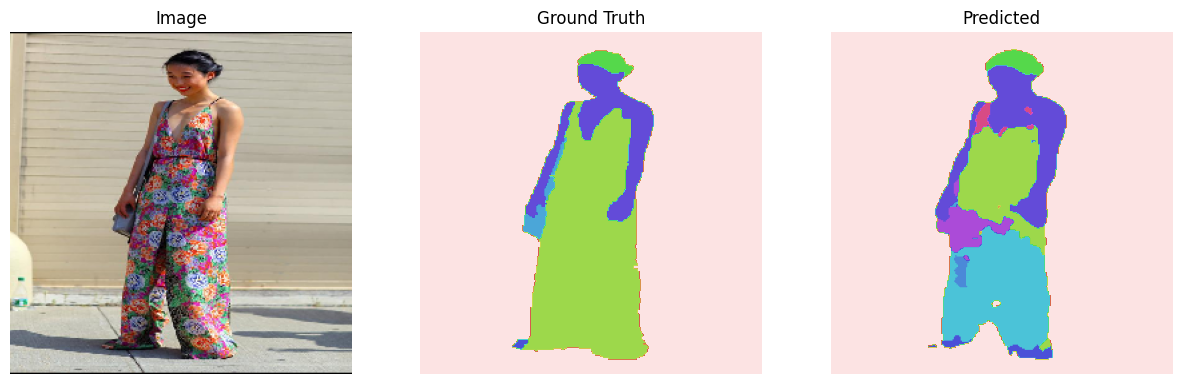

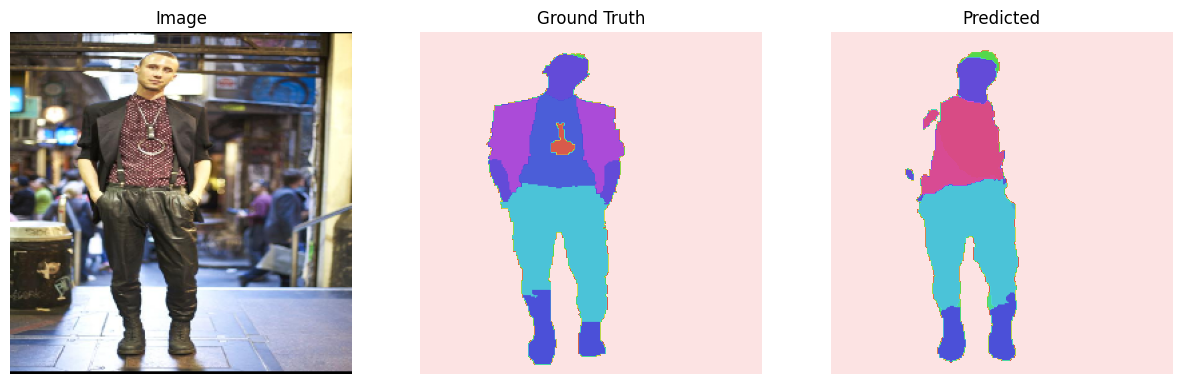

In [19]:
for images, masks in test_loader:
    for image, mask in zip(images, masks):
        visualize_prediction(model.model, (image, mask), device=model.device)
    break

The results obtained by the best identified model are presented above. While there is a lot of things to improve, people and a lot of the clothes elements are found correctly.

To improve the result even further the following methods might be used:
* Hyperparameter tuning
* Backbone tuning (now we just use `resnet34`)
* etc.

In [20]:
# Saved history from the first run
history = {'train_loss': [
  1.3949574941396714,
  0.5988306933641434,
  0.42761779874563216,
  0.3361550997197628,
  0.2704618512094021,
  0.23379520282149316,
  0.20472809672355652,
  0.18476217329502106,
  0.16440226554870604,
  0.15162754483520985,
  0.14423220850527285],
 'val_loss': [
  0.7934489800379827,
  0.5385729074478149,
  0.48884323239326477,
  0.4731959838133592,
  0.43894572670643145,
  0.49118605026831996,
  0.47861103140390837,
  0.47183117958215565,
  0.4634859309746669,
  0.47008816783244795,
  0.4975955050725203],
 'val_metrics': {'iou': [
   0.3862331945162553,
   0.3680395002548511,
   0.3566247786466892,
   0.3484913431681119,
   0.33889241287341487,
   0.3410874456167221,
   0.338061674283101,
   0.33551211884388554,
   0.3298393258681664,
   0.32702227051441485,
   0.33165056430376494],
  'dice': [
   0.36560341715812683,
   0.34140492861087507,
   0.3261398501121081,
   0.3165527398769672,
   0.30506225618032307,
   0.3086063449199383,
   0.30411378466165984,
   0.30187033919187695,
   0.29525308540234196,
   0.2915535821364476,
   0.2976802530196997]}}

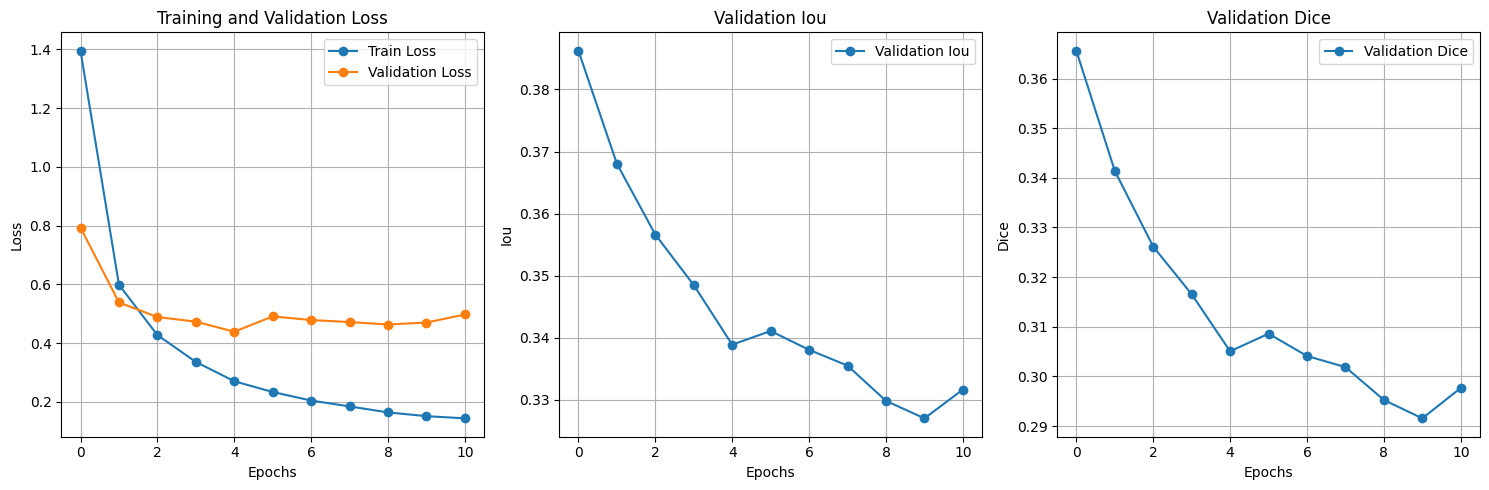

In [21]:
plot_history(history)

Above we present the learning process of the final model. It stopped on 11th iterations due to 5 iterations without improvement on validation set. Such plot on the left might show that overfitting on the training set has started.